   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.4/703.4 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.5 MB/s eta 0:00:00
Mounted at /content/drive
No process on 5000
MLflow Tracking UI: NgrokTunnel: "https://8f02551b55df.ngrok-free.app" -> "http://localhost:5000"
Dataset Shape: (119390, 32)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 

2025/09/01 16:33:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/01 16:33:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/09/01 16:33:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Hotel_Booking_Cancellation_Predictor_ANN' already exists. Creating a new version of this model...
Created version '3' of model 'Hotel_Booking_Cancellation_Predictor_ANN'.


Accuracy: 0.8517044978641427
ROC AUC: 0.9353526255804218

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88     15033
           1       0.77      0.85      0.81      8845

    accuracy                           0.85     23878
   macro avg       0.84      0.85      0.84     23878
weighted avg       0.86      0.85      0.85     23878


Confusion Matrix:
 [[12854  2179]
 [ 1362  7483]]

MLflow run completed! Run ID: b3df7d312fb34e60a4f3fa6d2983208a


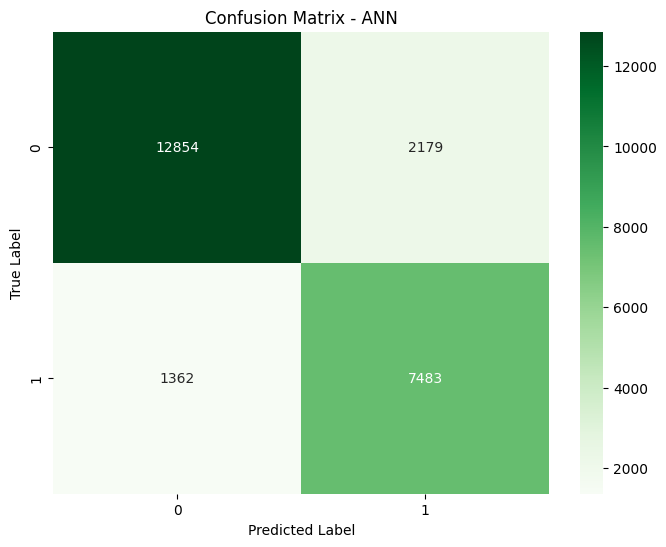

In [ ]:
# =========================
# Install & Import Packages
# =========================
!pip install mlflow pyngrok

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from tensorflow import keras
from pyngrok import ngrok
import mlflow
import mlflow.sklearn
import os

warnings.filterwarnings('ignore')

# =========================
# Mount Google Drive (persistent storage for MLflow)
# =========================
from google.colab import drive
drive.mount('/content/drive')

# Create MLflow tracking folder in Drive
mlflow_dir = "/content/drive/MyDrive/mlruns"
os.makedirs(mlflow_dir, exist_ok=True)

# Set MLflow tracking URI
mlflow.set_tracking_uri(f"file:{mlflow_dir}")
mlflow.set_experiment("Hotel_Booking_Experiment_LogReg")

# =========================
# Start MLflow UI with ngrok
# =========================
ngrok.set_auth_token("323hZ4nUB9GUXYu9d0eByl7bmP1_4RBDzJSU2qSx2g4gYJHzK")  # replace with your token

# Kill any existing ngrok tunnels before starting a new one
ngrok.kill()

# Kill any MLflow UI running on port 5000
get_ipython().system("fuser -k 5000/tcp || echo 'No process on 5000'")

# Start MLflow UI in background
get_ipython().system_raw(f"mlflow ui --backend-store-uri file:{mlflow_dir} --port 5000 &")

# Create fresh public URL with ngrok
public_url = ngrok.connect(5000, "http")
print("MLflow Tracking UI:", public_url)

# =========================
# Load Dataset
# =========================
df = pd.read_csv("hotel_bookings.csv")

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum().sort_values(ascending=False))
print("\nCancellation Rate:")
print(df['is_canceled'].value_counts(normalize=True))

# =========================
# Data Preprocessing
# =========================
df_clean = df.copy()

# Convert arrival_date_month to numeric
month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
             'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df_clean['arrival_date_month'] = df_clean['arrival_date_month'].map(month_map)

# Fill missing values
num_cols = ['lead_time','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month',
            'stays_in_weekend_nights','stays_in_week_nights','adults','children','babies',
            'is_repeated_guest','previous_cancellations','previous_bookings_not_canceled',
            'booking_changes','days_in_waiting_list','adr',
            'required_car_parking_spaces','total_of_special_requests','arrival_date_month']
cat_cols = ['hotel','meal','country','market_segment','distribution_channel','reserved_room_type',
            'assigned_room_type','deposit_type','agent','company','customer_type']

for col in num_cols:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

for col in cat_cols:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Drop leakage column
df_clean.drop('reservation_status_date', axis=1, inplace=True)

# Feature Engineering
df_clean['total_nights'] = df_clean['stays_in_weekend_nights'] + df_clean['stays_in_week_nights']
df_clean['total_guests'] = df_clean['adults'] + df_clean['children'] + df_clean['babies']
df_clean['has_children'] = (df_clean['children'] > 0).astype(int)
df_clean['has_babies'] = (df_clean['babies'] > 0).astype(int)
df_clean['is_family'] = ((df_clean['children'] > 0) | (df_clean['babies'] > 0)).astype(int)

# Encode categorical variables
label_encoders = {}
encode_cols = ['hotel','meal','country','market_segment','distribution_channel',
               'reserved_room_type','assigned_room_type','deposit_type','customer_type']
for col in encode_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

df_clean.drop(['reservation_status'], axis=1, inplace=True)

# Features & Target
X = df_clean.drop('is_canceled', axis=1)
y = df_clean['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# =========================
# Train Artificial Neural Network with MLflow
# =========================
print("Training Neural Network Model with MLflow tracking...")

from tensorflow.keras import layers

with mlflow.start_run(run_name="ANN_Final"):
    # Build the model
    nn_model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile
    nn_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name="auc")]
    )

    # Train
    history = nn_model.fit(
        X_train_scaled, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        class_weight={0: 1, 1: 2}
    )

    # Predictions
    y_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
    y_pred_proba_nn = nn_model.predict(X_test_scaled)

    # Metrics
    acc = accuracy_score(y_test, y_pred_nn)
    roc_auc = roc_auc_score(y_test, y_pred_proba_nn)
    report_dic = classification_report(y_test, y_pred_nn, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_nn)

    # Log params
    mlflow.log_params({
        "model_type": "ANN",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "epochs": 50,
        "batch_size": 32,
        "class_weight": "{0:1, 1:2}"
    })

    # Log metrics
    mlflow.log_metrics({
        "accuracy": acc,
        "roc_auc": roc_auc,
        "precision_0": report_dic['0']['precision'],
        "recall_0": report_dic['0']['recall'],
        "f1_score_0": report_dic['0']['f1-score'],
        "precision_1": report_dic['1']['precision'],
        "recall_1": report_dic['1']['recall'],
        "f1_score_1": report_dic['1']['f1-score']
    })

    # Log model
    mlflow.keras.log_model(nn_model, "ann_model",
                           registered_model_name="Hotel_Booking_Cancellation_Predictor_ANN")

    # Confusion matrix plot
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title("Confusion Matrix - ANN")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_ann.png")
    mlflow.log_artifact("confusion_matrix_ann.png")

    print("Accuracy:", acc)
    print("ROC AUC:", roc_auc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))
    print("\nConfusion Matrix:\n", cm)
    print(f"\nMLflow run completed! Run ID: {mlflow.active_run().info.run_id}")

In [ ]:
!pkill ngrok
